# Trabalho prático - Visão por Computador e Processamento de Imagem

#### Autores: Cláudio Moreira (PG47844), Filipe Fernandes(A83996)

Para o presente trabalho foi proposta a exploração de modelos de Deep Learning. Numa primeira parte, é suposto treinar modelos aplicando data augmentation, tanto em pré-processamento como dinâmico.

Neste *notebook*, explorou-se em detalhe o *dataset* original sem efetuar nenhuma alteração. Sendo assim, começou-se por importar os módulos necessários para o desenvolvimento do projeto.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [2]:
#GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Avasilable: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Avasilable:  0


IndexError: list index out of range

### Funções Auxiliares

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])


def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


In [4]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [5]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

### Paths para os datasets

In [6]:
pathTrain = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'


### Tamanho da Batch

In [7]:
BATCH_SIZE = 32

### Preparação da data de Treino

In [8]:
#Ver as classes
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00013' '00025' '00003' '00028' '00035' '00026' '00036' '00027' '00001'
 '00019' '00020' '00042' '00002' '00038' '00021' '00024' '00034' '00029'
 '00033' '00006' '00041' '00017' '00030' '00009' '00040' '00000' '00004'
 '00015' '00008' '00012' '00016' '00037' '00022' '00039' '00010' '00031'
 '00005' '00011' '00023' '00018' '00014' '00032' '00007']


#### Carregamento de Imagens

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

2022-05-27 14:08:32.520114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 14:08:32.520826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 14:08:32.520979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 14:08:32.521051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)
#print(dataset)
# note: this only works if dataset is not repeating
train_Data_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", train_Data_length)  

(32, 32, 3) (43,)
Total images in dataset:  39209


In [11]:
train_Dataset = dataset
train_Dataset = train_Dataset.cache()
train_Dataset = train_Dataset.shuffle(buffer_size = train_Data_length)
train_Dataset = train_Dataset.batch(batch_size=BATCH_SIZE)
train_Dataset = train_Dataset.prefetch(buffer_size = AUTOTUNE)
train_Dataset = train_Dataset.repeat()

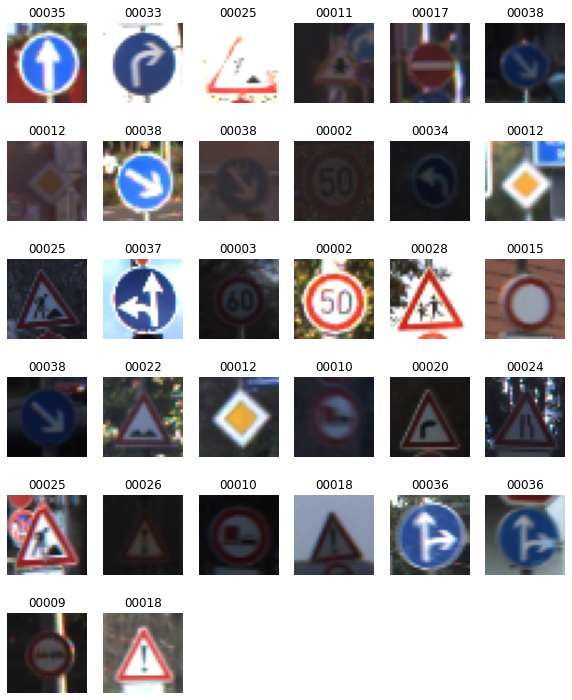

In [12]:
image_batch, label_batch = next(iter(train_Dataset))        
show_batch(image_batch, label_batch.numpy())

### Preparação da data validada

In [8]:
train_size = int(0.8*train_Data_length)
val_size = int(0.2*train_Data_length)
print(train_Data_length)
print(train_size)


NameError: name 'train_Data_length' is not defined

In [9]:
train_Data = train_Dataset.take(train_size)
val_Data = train_Dataset.skip(train_size)
print(tf.data.experimental.cardinality(train_Data).numpy())

NameError: name 'train_Dataset' is not defined

In [15]:
#train_Data = train_Dataset.take(train_size)
#val_Data = train_Dataset.skip(train_size)
print(tf.data.experimental.cardinality(val_Data).numpy())

-1


In [16]:
#image_batch, label_batch = next(iter(val_Data))        
#show_batch(image_batch, label_batch.numpy())

### Preparação da data de teste

In [17]:
#ver as classes
data_dir = pathlib.Path(pathTest)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00013' '00025' '00003' '00028' '00035' '00026' '00036' '00027' '00001'
 '00019' '00020' '00042' '00002' '00038' '00021' '00024' '00034' '00029'
 '00033' '00006' '00041' '00017' '00030' '00009' '00040' '00000' '00004'
 '00015' '00008' '00012' '00016' '00037' '00022' '00039' '00010' '00031'
 '00005' '00011' '00023' '00018' '00014' '00032' '00007']


In [18]:
listset = tf.data.Dataset.list_files(pathTest+"/*/*.png")
test_Data = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [19]:
# t = next(iter(dataset_test))
# print(t[0].shape, t[1].shape)
# #print(dataset)
test_Data_length = tf.data.experimental.cardinality(test_Data).numpy()
print("Total images in dataset: ", test_Data_length)  


Total images in dataset:  12630


In [20]:
test_Data = test_Data.batch(batch_size = BATCH_SIZE)

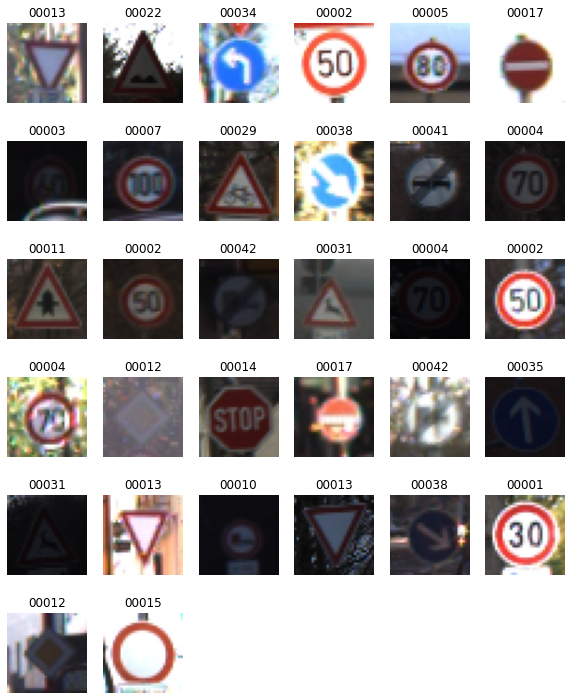

In [21]:
image_batch, label_batch = next(iter(test_Data))        
show_batch(image_batch, label_batch.numpy())

### Criação do Modelo

In [22]:

model = Sequential()

model.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
model.add(LeakyReLU(alpha=0.01))  
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(196, (5, 5) )) 
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(256, (5, 5) ) )   
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Flatten())
model.add(LeakyReLU(alpha=0.0)) 
model.add(Dense(384))
model.add(LeakyReLU(alpha=0.0))             
model.add(Dropout(0.5)) 

model.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])


In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 196)       627396    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 196)       0         
                                                        

### Treino do Modelo

In [24]:
file_path = './TrainModels/noAugmentation.ckpt'

callbacks = prepare_callbacks(file_path)

history = model.fit(train_Data, steps_per_epoch = 0.8 * train_Data_length/BATCH_SIZE,
          epochs=30, 
          validation_data=val_Data,
          validation_steps=0.2*train_Data_length/BATCH_SIZE, 
          callbacks = callbacks)

Epoch 1/30


2022-05-27 14:08:37.678845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-05-27 14:08:38.277039: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


979/980 [============================>.] - ETA: 0s - loss: 2.1170 - accuracy: 0.4399
Epoch 1: val_accuracy improved from -inf to 0.89012, saving model to ./TrainModels/noAugmentation.ckpt
980/980 [==============================] - 26s 25ms/step - loss: 2.1146 - accuracy: 0.4405 - val_loss: 0.4545 - val_accuracy: 0.8901 - lr: 1.0000e-04
Epoch 2/30
979/980 [============================>.] - ETA: 0s - loss: 0.5619 - accuracy: 0.8283
Epoch 2: val_accuracy improved from 0.89012 to 0.97332, saving model to ./TrainModels/noAugmentation.ckpt
980/980 [==============================] - 25s 25ms/step - loss: 0.5616 - accuracy: 0.8285 - val_loss: 0.1083 - val_accuracy: 0.9733 - lr: 1.0000e-04
Epoch 3/30
981/980 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9209
Epoch 3: val_accuracy improved from 0.97332 to 0.98463, saving model to ./TrainModels/noAugmentation.ckpt
980/980 [==============================] - 24s 24ms/step - loss: 0.2591 - accuracy: 0.9209 - val_loss: 0.057

### Load Modelo treinado

In [25]:
#model.load_weights(file_path)

#evalV1 = model.evaluate(test_Data, verbose=2)
#valV1 = model.evaluate(val_Data, steps=1, batch_size=0.2 * train_Data_length, verbose=2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


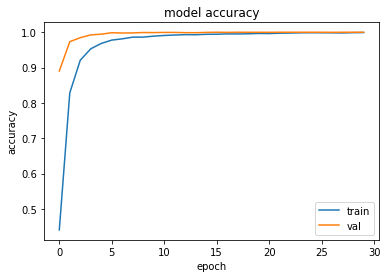

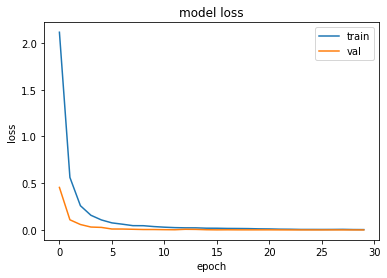

In [26]:
show_history(history)

In [27]:
model_eval = model.evaluate(test_Data, verbose=2)
print(model_eval)

model_val = model.evaluate(val_Data, steps=1, batch_size=0.2 * train_Data_length, verbose=2)
print(model_val)

395/395 - 3s - loss: 0.0627 - accuracy: 0.9857 - 3s/epoch - 8ms/step
[0.06268534064292908, 0.9856690168380737]
1/1 - 2s - loss: 2.9081e-05 - accuracy: 1.0000 - 2s/epoch - 2s/step
[2.9081305910949595e-05, 1.0]


### Más classificações

In [28]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in test_Data.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(model.predict(images.numpy()))


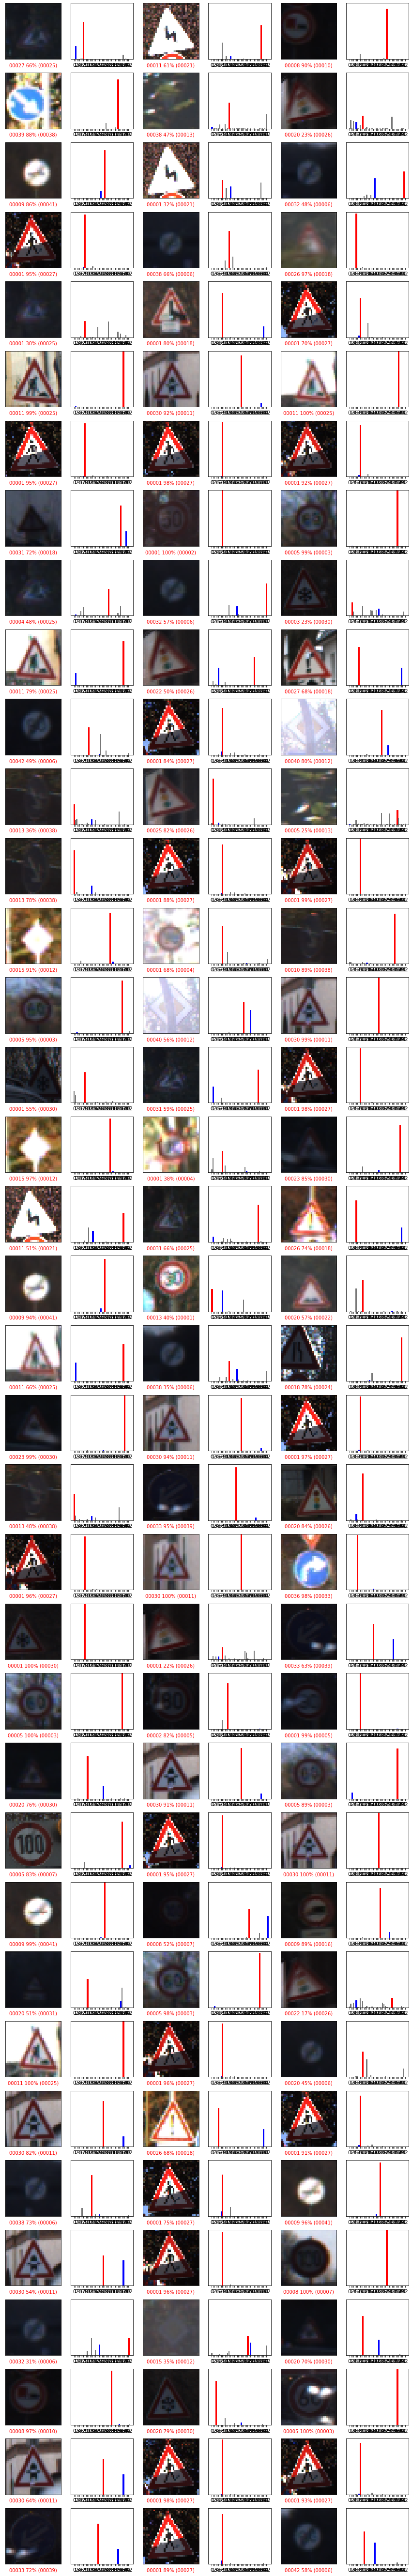

In [29]:
show_misclassified(pred, numpy_labels, numpy_images, int((val_size - val_size*.9861 )/3 + 1))